In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
import lightgbm as lgb
import warnings
import pickle

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='seaborn')
%matplotlib inline

In [ ]:
train_id = pd.read_csv ("/content/drive/MyDrive/Datasets/DS 2/train_identity.csv")
train_transaction = pd.read_csv("/content/drive/MyDrive/Datasets/DS 2/train_transaction.csv")
test_id = pd.read_csv ("/content/drive/MyDrive/Datasets/DS 2/test_identity.csv")
test_transaction = pd.read_csv ("/content/drive/MyDrive/Datasets/DS 2/test_transaction.csv")

In [ ]:
print(train_id.info())
print(train_transaction.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [ ]:
train_id.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

In [ ]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [ ]:
train = pd.merge (train_transaction, train_id, how = 'left', on = 'TransactionID', left_index=True, right_index=True)

In [ ]:
  test = pd.merge (test_transaction, test_id, how='left', on = 'TransactionID', left_index=True, right_index=True)

In [ ]:
print (train.shape)
print (test.shape)
del train_transaction
del test_transaction
del train_id
del test_id

(590540, 434)
(506691, 433)


In [ ]:
train.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000     214.000000     150.000000     166.000000   
50%      9678.000000     361.000000     150.000000     226.000000   
75%     14184.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2          dist1         dist2  \
count  524834.000000  524834.000000  238269.000000  37627.000000   
mean      290.733794      86.800630     118.502180    231.855423   
std       101.741072       2.690623     371.872026    529.053494   
min       100.000000      10.000000       0.000000      0.000000   
25%       204.000000      87.000000       3.000000      7.000000   
50%       299.000000      87.000000       8.000000     37.000000   
75%       330.000000      87.000000      24.000000    206.000000   
max       540.000000     102.000000   10286.000000  11623.000000   

                  C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14             D1             D2  \
count  590540.000000  590540.000000  589271.000000  309743.000000   
mean       32.539918       8.295215      94.347568     169.563231   
std       129.364844      49.544262     157.660387     177.315865   

In [ ]:
test.describe()

TransactionID  TransactionDT  TransactionAmt          card1  \
count   5.066910e+05   5.066910e+05   506691.000000  506691.000000   
mean    3.916894e+06   2.692994e+07      134.725568    9957.222175   
std     1.462692e+05   4.756507e+06      245.779822    4884.960969   
min     3.663549e+06   1.840322e+07        0.018000    1001.000000   
25%     3.790222e+06   2.277154e+07       40.000000    6019.000000   
50%     3.916894e+06   2.720466e+07       67.950000    9803.000000   
75%     4.043566e+06   3.134856e+07      125.000000   14276.000000   
max     4.170239e+06   3.421434e+07    10270.000000   18397.000000   

               card2          card3          card5          addr1  \
count  498037.000000  503689.000000  502144.000000  441082.000000   
mean      363.735379     153.543409     200.162975     291.846514   
std       158.688653      12.443013      40.562461     102.062730   
min       100.000000     100.000000     100.000000     100.000000   
25%       207.000000     150.000000     166.000000     204.000000   
50%       369.000000     150.000000     226.000000     299.000000   
75%       512.000000     150.000000     226.000000     330.000000   
max       600.000000     232.000000     237.000000     540.000000   

               addr2          dist1         dist2             C1  \
count  441082.000000  215474.000000  36436.000000  506688.000000   
mean       86.723412      87.065270    237.175047      10.093211   
std         2.987328     314.131694    556.450834      79.334782   
min        10.000000       0.000000      0.000000       0.000000   
25%        87.000000       3.000000      7.000000       1.000000   
50%        87.000000       8.000000     44.000000       1.000000   
75%        87.000000      20.000000    196.000000       3.000000   
max       102.000000    8081.000000   9213.000000    2950.000000   

                  C2             C3             C4             C5  \
count  506688.000000  506688.000000  506688.000000  506688.000000   
mean       10.714635       0.027403       2.385875       4.962701   
std        88.896921       0.227753      41.942977      25.462195   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       0.000000       0.000000       0.000000   
75%         3.000000       0.000000       1.000000       1.000000   
max      3275.000000      31.000000    1601.000000     376.000000   

                  C6             C7             C8             C9  \
count  506688.000000  506688.000000  506688.000000  506688.000000   
mean        6.854992       1.678173       1.893994       4.611943   
std        46.783565      37.874827      26.766115      21.282640   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       0.000000       0.000000       1.000000   
75%         2.000000       0.000000       1.000000       2.000000   
max      1601.000000    1621.000000    1005.000000     572.000000   

                 C10            C11            C12            C13  \
count  506688.000000  506688.000000  506688.000000  501943.000000   
mean        1.810149       7.484594       2.649486      27.816035   
std        23.692393      61.322505      53.973060     101.114033   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       1.000000   
50%         0.000000       1.000000       0.000000       3.000000   
75%         1.000000       2.000000       1.000000      13.000000   
max       881.000000    2234.000000    2234.000000    1562.000000   

                 C14             D1             D2             D3  \
count  506688.000000  500660.000000  271922.000000  303549.000000   
mean        6.083890     108.207504     188.666621      33.394727   
std        28.315616     176.964526     197.099611      82.558210   

In [ ]:
target = train['isFraud']

In [ ]:
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [ ]:
def differentcolumns(traincols, testcols):
  for i in traincols:
    if i not in testcols:
      print(i)

In [ ]:
differentcolumns(train.columns, test.columns)

isFraud
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [ ]:
test = test.rename (columns={"id-01":"id_01", "id-02":"id_02", "id-03":"id_03", "id-04":"id_04", "id-05":"id_05", "id-06":"id_06", "id-07":"id_07", "id-08":"id_08", "id-09":"id_09", "id-10":"id_10", "id-11":"id_11", "id-12":"id_12", "id-13":"id_13", "id-14":"id_14", "id-15":"id_15", "id-16":"id_16", "id-17":"id_17", "id-18":"id_18", "id-19":"id_19", "id-20":"id_20", "id-21":"id_21", "id-22":"id_22", "id-23":"id_23", "id-24":"id_24", "id-25":"id_25", "id-26":"id_26", "id-27":"id_27", "id-28":"id_28", "id-29":"id_29", "id-30":"id_30", "id-31":"id_31", "id-32":"id_32", "id-33":"id_33", "id-34":"id_34", "id-35":"id_35", "id-36":"id_36", "id-37":"id_37", "id-38":"id_38"})

In [ ]:
train

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400           68.50         W   
1             2987001        0          86401           29.00         W   
2             2987002        0          86469           59.00         W   
3             2987003        0          86499           50.00         W   
4             2987004        0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047           49.00         W   
590536        3577536        0       15811049           39.50         W   
590537        3577537        0       15811079           30.95         W   
590538        3577538        0       15811088          117.00         W   
590539        3577539        0       15811131          279.95         W   

        card1  card2  card3       card4  card5   card6  addr1  addr2  dist1  \
0       13926    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0   
1        2755  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN   
2        4663  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0   
3       18132  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN   
4        4497  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN   
...       ...    ...    ...         ...    ...     ...    ...    ...    ...   
590535   6550    NaN  150.0        visa  226.0   debit  272.0   87.0   48.0   
590536  10444  225.0  150.0  mastercard  224.0   debit  204.0   87.0    NaN   
590537  12037  595.0  150.0  mastercard  224.0   debit  231.0   87.0    NaN   
590538   7826  481.0  150.0  mastercard  224.0   debit  387.0   87.0    3.0   
590539  15066  170.0  150.0  mastercard  102.0  credit  299.0   87.0    NaN   

        dist2 P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7  \
0         NaN           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
1         NaN     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2         NaN   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
3         NaN     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0   
4         NaN     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
...       ...           ...           ...  ...  ...  ...  ...  ...  ...  ...   
590535    NaN           NaN           NaN  2.0  1.0  0.0  0.0  1.0  0.0  0.0   
590536    NaN     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
590537    NaN     gmail.com           NaN  1.0  1.0  0.0  0.0  1.0  1.0  0.0   
590538    NaN       aol.com           NaN  1.0  1.0  0.0  0.0  0.0  3.0  0.0   
590539    NaN     gmail.com           NaN  2.0  1.0  0.0  0.0  1.0  1.0  0.0   

         C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  \
0       0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN   
1       0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN   
2       0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN   
3       0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN   
4       1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN   
...     ...  ...  ...  ...  ...   ...  ...    ...    ...   ...   ...  ...  ..   
590535  0.0  2.0  0.0  1.0  0.0   3.0  2.0   29.0   29.0  30.0   NaN  NaN NaN   
590536  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN   
590537  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN   
590538  0.0  2.0  0.0  1.0  1.0   5.0  1.0   22.0   22.0   0.0  22.0  0.0 NaN   
590539  0.0  2.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   0.0   1.0  0.0 NaN   

        D7  D8  D9   D10    D11  D12  D13  D14    D15   M1   M2   M3   M4  \
0      NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2   
1      NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN  

In [ ]:
test

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224          31.950         W  10409  111.0   
1             3663550       18403263          49.000         W   4272  111.0   
2             3663551       18403310         171.000         W   4476  574.0   
3             3663552       18403310         284.950         W  10989  360.0   
4             3663553       18403317          67.950         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279          94.679         C  13832  375.0   
506687        4170236       34214287          12.173         C   3154  408.0   
506688        4170237       34214326          49.000         W  16661  490.0   
506689        4170238       34214337         202.000         W  16621  516.0   
506690        4170239       34214345          24.346         C   5713  168.0   

        card3       card4  card5   card6  addr1  addr2   dist1  dist2  \
0       150.0        visa  226.0   debit  170.0   87.0     1.0    NaN   
1       150.0        visa  226.0   debit  299.0   87.0     4.0    NaN   
2       150.0        visa  226.0   debit  472.0   87.0  2635.0    NaN   
3       150.0        visa  166.0   debit  205.0   87.0    17.0    NaN   
4       150.0  mastercard  117.0   debit  264.0   87.0     6.0    NaN   
...       ...         ...    ...     ...    ...    ...     ...    ...   
506686  185.0  mastercard  224.0   debit  284.0   60.0     NaN    NaN   
506687  185.0  mastercard  224.0   debit    NaN    NaN     NaN  157.0   
506688  150.0        visa  226.0   debit  327.0   87.0     NaN    NaN   
506689  150.0  mastercard  224.0   debit  177.0   87.0     NaN    NaN   
506690  144.0        visa  147.0  credit    NaN    NaN     NaN    NaN   

       P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8  \
0          gmail.com           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0   
1            aol.com           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0   
2        hotmail.com           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0   
3          gmail.com           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0   
4          gmail.com           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0   
...              ...           ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686     gmail.com     gmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   
506687   hotmail.com   hotmail.com  1.0  3.0  0.0  1.0  0.0  1.0  1.0  2.0   
506688   hotmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
506689   hotmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
506690   hotmail.com   hotmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0   

         C9  C10  C11  C12    C13  C14     D1     D2    D3     D4    D5    D6  \
0       6.0  0.0  5.0  1.0  115.0  6.0  419.0  419.0  27.0  398.0  27.0   NaN   
1       2.0  0.0  1.0  1.0   12.0  2.0  149.0  149.0   7.0  634.0   7.0   NaN   
2       4.0  0.0  2.0  0.0   22.0  2.0  137.0  137.0  10.0   97.0  10.0   NaN   
3       2.0  0.0  2.0  0.0    7.0  4.0   42.0   42.0  41.0  242.0  41.0   NaN   
4       5.0  0.0  6.0  0.0   14.0  6.0   22.0   22.0   0.0   22.0   0.0   NaN   
...     ...  ...  ...  ...    ...  ...    ...    ...   ...    ...   ...   ...   
506686  0.0  0.0  1.0  1.0    1.0  1.0    0.0    NaN   NaN    0.0   NaN   0.0   
506687  0.0  2.0  1.0  1.0    3.0  1.0   16.0   16.0  16.0   16.0  16.0  16.0   
506688  1.0  0.0  1.0  0.0    1.0  1.0    0.0    NaN   NaN    0.0   NaN   NaN   
506689  1.0  0.0  1.0  0.0    1.0  1.0    0.0    NaN   NaN    0.0   NaN   NaN   
506690  0.0  1.0  1.0  1.0    1.0  1.0    0.0    NaN   NaN    0.0   NaN   0.0   

          D7         D8        D9    D10    D11   D12  D13  D14    D15   M1  \
0        NaN        NaN       NaN  418.0  203.0   NaN  NaN  NaN  409.0    T   
1        NaN        NaN       NaN  231.0  634.0   NaN  NaN  NaN  634.0    T   
2        NaN        NaN

In [ ]:
differentcolumns(train.columns, test.columns)

isFraud


In [ ]:
train.isnull().sum().sum()

115523073

In [ ]:
train.isnull().count()

TransactionID     590540
isFraud           590540
TransactionDT     590540
TransactionAmt    590540
ProductCD         590540
                   ...  
id_36             590540
id_37             590540
id_38             590540
DeviceType        590540
DeviceInfo        590540
Length: 434, dtype: int64

In [ ]:
def getnulls(x):
  total = x.isnull().sum().sort_values(ascending=False)
  percent = (x.isnull().sum() / x.isnull().count()). sort_values(ascending=False)
  missing_data = pd.concat ([total, percent], axis=1, keys=['total', 'percent'])
  return missing_data

In [ ]:
train_missing_data = getnulls(train)

In [ ]:
train_missing_data.head(350).T

id_24         id_25          id_07          id_08  \
total    585793.000000  585408.00000  585385.000000  585385.000000   
percent       0.991962       0.99131       0.991271       0.991271   

                 id_21          id_26          id_22          id_23  \
total    585381.000000  585377.000000  585371.000000  585371.000000   
percent       0.991264       0.991257       0.991247       0.991247   

                 id_27          dist2             D7          id_18  \
total    585371.000000  552913.000000  551623.000000  545427.000000   
percent       0.991247       0.936284       0.934099       0.923607   

                   D13            D14           D12          id_04  \
total    528588.000000  528353.000000  525823.00000  524216.000000   
percent       0.895093       0.894695       0.89041       0.887689   

                 id_03             D6          id_33          id_10  \
total    524216.000000  517353.000000  517251.000000  515614.000000   
percent       0.887689       0.876068       0.875895       0.873123   

                    D8             D9          id_09          id_30  \
total    515614.000000  515614.000000  515614.000000  512975.000000   
percent       0.873123       0.873123       0.873123       0.868654   

                 id_32          id_34          id_14           V149  \
total    512954.000000  512735.000000  510496.000000  508595.000000   
percent       0.868619       0.868248       0.864456       0.861237   

                  V153           V156           V154           V155  \
total    508595.000000  508595.000000  508595.000000  508595.000000   
percent       0.861237       0.861237       0.861237       0.861237   

                  V157           V158           V161           V163  \
total    508595.000000  508595.000000  508595.000000  508595.000000   
percent       0.861237       0.861237       0.861237       0.861237   

                  V147           V148           V162           V146  \
total    508595.000000  508595.000000  508595.000000  508595.000000   
percent       0.861237       0.861237       0.861237       0.861237   

                  V138           V139           V140           V141  \
total    508595.000000  508595.000000  508595.000000  508595.000000   
percent       0.861237       0.861237       0.861237       0.861237   

                  V142           V166           V164           V160  \
total    508595.000000  508589.000000  508589.000000  508589.000000   
percent       0.861237       0.861227       0.861227       0.861227   

                  V159           V143           V144           V145  \
total    508589.000000  508589.000000  508589.000000  508589.000000   
percent       0.861227       0.861227       0.861227       0.861227   

                  V152           V151           V150           V165  \
total    508589.000000  508589.000000  508589.000000  508589.000000   
percent       0.861227       0.861227       0.861227       0.861227   

                 V339          V322          V338          V337          V336  \
total    508189.00000  508189.00000  508189.00000  508189.00000  508189.00000   
percent       0.86055       0.86055       0.86055       0.86055       0.86055   

                 V335          V334          V333          V332          V331  \
total    508189.00000  508189.00000  508189.00000  508189.00000  508189.00000   
percent       0.86055       0.86055       0.86055       0.86055       0.86055   

                 V330          V329          V328          V327          V326  \
total    508189.00000  508189.00000  508189.00000  508189.00000  508189.00000   
percent       0.86055       0.86055       0.86055       0.86055       0.86055   

                 V325          V324          V323     DeviceInfo  \
total    508189.00000  508189.00000  508189.00000  471874.000000   
percent       0.86055       0.86055       0.86055       0.799055   

                 id_13         id_16           V237           V230  \
total    463220.0000

In [ ]:
test_missing_data = getnulls(test)
test_missing_data.head(350).T

id_24          id_25          id_26          id_07  \
total    501951.000000  501652.000000  501644.000000  501632.000000   
percent       0.990645       0.990055       0.990039       0.990016   

                 id_08          id_21         id_27         id_22  \
total    501632.000000  501632.000000  501629.00000  501629.00000   
percent       0.990016       0.990016       0.99001       0.99001   

                id_23         dist2          id_18             D7  \
total    501629.00000  470255.00000  455816.000000  446558.000000   
percent       0.99001       0.92809       0.899594       0.881322   

                 id_04          id_03            D12          id_30  \
total    440210.000000  440210.000000  437437.000000  436032.000000   
percent       0.868794       0.868794       0.863321       0.860548   

                 id_32          id_33          id_14          id_34  \
total    436020.000000  436020.000000  435334.000000  434516.000000   
percent       0.860524       0.860524       0.859171       0.857556   

                 id_09             D9          id_10             D8  \
total    432353.000000  432353.000000  432353.000000  432353.000000   
percent       0.853287       0.853287       0.853287       0.853287   

                  V153           V157           V154           V155  \
total    430906.000000  430906.000000  430906.000000  430906.000000   
percent       0.850432       0.850432       0.850432       0.850432   

                  V156           V158           V148           V161  \
total    430906.000000  430906.000000  430906.000000  430906.000000   
percent       0.850432       0.850432       0.850432       0.850432   

                  V162           V163           V149           V147  \
total    430906.000000  430906.000000  430906.000000  430906.000000   
percent       0.850432       0.850432       0.850432       0.850432   

                  V146           V138           V139           V140  \
total    430906.000000  430906.000000  430906.000000  430906.000000   
percent       0.850432       0.850432       0.850432       0.850432   

                  V141           V142           V166           V164  \
total    430906.000000  430906.000000  430636.000000  430636.000000   
percent       0.850432       0.850432       0.849899       0.849899   

                  V160           V159           V143           V144  \
total    430636.000000  430636.000000  430636.000000  430636.000000   
percent       0.849899       0.849899       0.849899       0.849899   

                  V145           V152           V165           V150  \
total    430636.000000  430636.000000  430636.000000  430636.000000   
percent       0.849899       0.849899       0.849899       0.849899   

                  V151           V328           V327           V339  \
total    430636.000000  430260.000000  430260.000000  430260.000000   
percent       0.849899       0.849157       0.849157       0.849157   

                  V338           V337           V336           V335  \
total    430260.000000  430260.000000  430260.000000  430260.000000   
percent       0.849157       0.849157       0.849157       0.849157   

                  V334           V333           V332           V331  \
total    430260.000000  430260.000000  430260.000000  430260.000000   
percent       0.849157       0.849157       0.849157       0.849157   

                  V330           V322           V323           V324  \
total    430260.000000  430260.000000  430260.000000  430260.000000   
percent       0.849157       0.849157       0.849157       0.849157   

                  V325           V329           V326     DeviceInfo  \
total    430260.000000  430260.000000  430260.000000  391634.000000   
percent       0.849157       0.849157       0.849157       0.772925   

                   D14            D13            D6          id_16  \
total    391497.000000  383307.000000  381908.00000  380944.000000   
percent       0.772654       0.756491

In [ ]:
droppedcols = train_missing_data[train_missing_data['total'] > 100000]. index

In [ ]:
droppedcols

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2',
       ...
       'V43', 'V49', 'V41', 'V40', 'V39', 'V38', 'V37', 'V36', 'V35', 'D4'],
      dtype='object', length=252)

In [ ]:
train.drop (droppedcols, axis=1, inplace=True)
test.drop (droppedcols, axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 182 entries, TransactionID to V321
dtypes: float64(174), int64(4), object(4)
memory usage: 820.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 181 entries, TransactionID to V321
dtypes: float64(174), int64(3), object(4)
memory usage: 699.7+ MB


In [ ]:
print(train.shape)
print(test.shape)

(590540, 182)
(506691, 181)


In [ ]:
train_missing_data = getnulls(train)
train_missing_data.head(200).T

P_emaildomain           V89           V75           V77  \
total     94456.000000  89164.000000  89164.000000  89164.000000   
percent       0.159949      0.150987      0.150987      0.150987   

                  V78           V79           V80           V81           V82  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  V83           V84           V85           V86           V87  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  V88           V90           V91           V92           V93  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  V76           V94           D15           V69           V70  \
total    89164.000000  89164.000000  89113.000000  77096.000000  77096.000000   
percent      0.150987      0.150987      0.150901      0.130552      0.130552   

                  V53           V54           V55           V56           V57  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V58           V59           V60           V61           V62  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V63           V64           V65           V66           V67  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V68           V74           V73           V72           V71  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V31           V32           V34           V33           V16  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V14           V29           V28           V27           V26  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V25           V24           V23           V22           V21  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V20           V19           V18           V17           V15  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V30           V13           V12           D10         addr2  \
total    76073.000000  76073.000000  76073.000000  76022.000000  65706.000000   
percent      0.128819      0.128819      0.128819      0.128733      0.111264   

                addr1        card2        card5       card4       card6  \
total    65706.000000  8933.000000  4259.000000  1577.00000  1571.00000   
percent      0.111264     0.015127     0.007212     0.00267     0.00266   

              card3         V315         V281         V282         V283  \
total    1565.00000  1269.000000  1269.000000  1269.000000  1269.000000   
percent     0.00265     0.002149     0.002149     0.002149     0.002149   

                V314         V288         V289         V301         V313  \
total    1269.000000  1269.000000  1269.000000  1269.000000  1269.000000   
percent     0.002149     0.0

In [ ]:
test_missing_data = getnulls(test)
test_missing_data.head(200).T

P_emaildomain         addr2         addr1           V71  \
total     69192.000000  65609.000000  65609.000000  12899.000000   
percent       0.136557      0.129485      0.129485      0.025457   

                  V70           V69           V68           V67           V66  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V65           V58           V63           V64           V73  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V62           V61           V60           V59           V53  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V54           V55           V56           V72           V57  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V74           V16           V18           V20           V21  \
total    12899.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.025457      0.024846      0.024846      0.024846      0.024846   

                  V22           V23           V25           V26           V27  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V28           V29           V30           V31           V32  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V33           V34           V17           V19           V15  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V14           V12           V13           V24           D10  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12545.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024759   

                  V88           V94           V81           V82           V83  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  V84           V76           V77           V93           V87  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  V92           V86           V78           V89           V75  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  V85           V91           V90           V79           V80  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  D15        card2         V282         V296         V315  \
total    12069.000000  8654.000000  6031.000000  6031.000000  6031.000000   
percent      0.023819     0.017079     0.011903     0.011903     0.011903   

                V314         V313         V283         V281         V300  \
total    6031.000000  6031.000000  6031.000000  6031.000000  6031.000000   
percent     0.011903     0.011903     0.011903     0.011903     0.011903   

                V301         V288         V289           D1          C13  \
total    6031.000000  6031.000000  6031.000000  6031.000000  4748.000000   
percent     0.01190

In [ ]:
train['P_emaildomain']

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: P_emaildomain, Length: 590540, dtype: object

In [ ]:
train['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
windstream.net         305
roadrunner.com         305
hotmail.es             305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [ ]:
target.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [ ]:
gmailc=0
yahooc=0
hotmailc=0
anonc=0
aolc=0
for i in range(train.shape[0]):
  if train['P_emaildomain'][i] == 'gmail.com' and train['isFraud'][i] == 1:
    gmailc+=1
  elif train['P_emaildomain'][i] == 'yahoo.com' and train['isFraud'][i] == 1:
    yahooc+=1
  elif train['P_emaildomain'][i] == 'hotmail.com' and train['isFraud'][i] == 1:
    hotmailc+=1
  elif train['P_emaildomain'][i] == 'anonymous.com' and train ['isFraud'][i] == 1:
    anonc+=1
  elif train['P_emaildomain'][i] == 'aol.com' and train['isFraud'][i] == 1:
    aolc+=1
print ("GMAIL: ", gmailc)
print ("YAHOO: ", yahooc)
print ("HOTMAIL: ", hotmailc)
print ("ANONYMOUS: ", anonc)
print ("AOL: ", aolc)

GMAIL:  9943
YAHOO:  2297
HOTMAIL:  2396
ANONYMOUS:  859
AOL:  617


In [ ]:
train.drop(['P_emaildomain'], axis=1, inplace=True)
test.drop(['P_emaildomain'], axis=1, inplace=True)

In [ ]:
print(train.shape)
print(test.shape)

(590540, 181)
(506691, 180)


In [ ]:
train_missing_data = getnulls(train)
train_missing_data.head(100).T

V90           V84           V77           V78           V79  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  V80           V81           V82           V83           V85  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  V75           V86           V87           V88           V89  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  V91           V92           V93           V76           V94  \
total    89164.000000  89164.000000  89164.000000  89164.000000  89164.000000   
percent      0.150987      0.150987      0.150987      0.150987      0.150987   

                  D15           V70           V62           V53           V54  \
total    89113.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.150901      0.130552      0.130552      0.130552      0.130552   

                  V55           V56           V57           V58           V59  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V60           V61           V63           V71           V64  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V65           V66           V67           V68           V69  \
total    77096.000000  77096.000000  77096.000000  77096.000000  77096.000000   
percent      0.130552      0.130552      0.130552      0.130552      0.130552   

                  V74           V73           V72           V32           V33  \
total    77096.000000  77096.000000  77096.000000  76073.000000  76073.000000   
percent      0.130552      0.130552      0.130552      0.128819      0.128819   

                  V34           V30           V15           V25           V24  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V23           V22           V21           V20           V27  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V19           V18           V17           V31           V28  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V16           V14           V13           V12           V29  \
total    76073.000000  76073.000000  76073.000000  76073.000000  76073.000000   
percent      0.128819      0.128819      0.128819      0.128819      0.128819   

                  V26           D10         addr2         addr1        card2  \
total    76073.000000  76022.000000  65706.000000  65706.000000  8933.000000   
percent      0.128819      0.128733      0.111264      0.111264     0.015127   

               card5       card4       card6       card3         V288  \
total    4259.000000  1577.00000  1571.00000  1565.00000  1269.000000   
percent     0.007212     0.00267     0.00266     0.00265     0.002149   

                V283         V282         V281         V300         V289  \
total    1269.000000  1269.000000  1269.000000  1269.000000  1269.000000   
percent     0.002149     0.002149     0.002149     0.002149     0.002149   

                V296         V301           D1         V313         V314  \
total    1269.000000  1269.000000  1269.000000  1269.000000  1269.000000   
perc

In [ ]:
test_missing_data = getnulls(test)
test_missing_data.head(100).T

addr2         addr1           V63           V71           V70  \
total    65609.000000  65609.000000  12899.000000  12899.000000  12899.000000   
percent      0.129485      0.129485      0.025457      0.025457      0.025457   

                  V69           V68           V67           V66           V65  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V58           V64           V73           V62           V61  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V60           V59           V53           V54           V55  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12899.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.025457   

                  V56           V72           V57           V74           V16  \
total    12899.000000  12899.000000  12899.000000  12899.000000  12589.000000   
percent      0.025457      0.025457      0.025457      0.025457      0.024846   

                  V18           V20           V21           V22           V23  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V24           V26           V27           V28           V29  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V30           V31           V32           V33           V34  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V17           V19           V25           V15           V14  \
total    12589.000000  12589.000000  12589.000000  12589.000000  12589.000000   
percent      0.024846      0.024846      0.024846      0.024846      0.024846   

                  V13           V12           D10           V94           V82  \
total    12589.000000  12589.000000  12545.000000  12081.000000  12081.000000   
percent      0.024846      0.024846      0.024759      0.023843      0.023843   

                  V83           V84           V85           V76           V77  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  V78           V87           V93           V88           V91  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  V79           V86           V89           V75           V92  \
total    12081.000000  12081.000000  12081.000000  12081.000000  12081.000000   
percent      0.023843      0.023843      0.023843      0.023843      0.023843   

                  V90           V80           V81           D15        card2  \
total    12081.000000  12081.000000  12081.000000  12069.000000  8654.000000   
percent      0.023843      0.023843      0.023843      0.023819     0.017079   

                V282         V283         V288         V289           D1  \
total    6031.000000  6031.000000  6031.000000  6031.000000  6031.000000   
percent     0.011903     0.011903     0.011903     0.011903     0.011903   

                V313         V296         V314         V315         V300  \
total    6031.000000  6031.000000  6031.000000  6031.000000  6031.000000   
percent     0.011903     0.011903     0.011903     0.011903     0.011903   

                V301         V281          C13        card5       card4  \
total    6031.000000  6031.000000  4748.000000  4547.000000  3086.0000

In [ ]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2   C1   C2   C3   C4  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0  1.0  1.0  0.0  0.0   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0  1.0  1.0  0.0  0.0   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  1.0  1.0  0.0  0.0   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0  2.0  5.0  0.0  0.0   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0  1.0  1.0  0.0  0.0   

    C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1   D10    D15  V12  \
0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0  13.0    0.0  1.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0   0.0    0.0  0.0   
2  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0   0.0  315.0  1.0   
3  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  84.0  111.0  1.0   
4  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0   NaN    NaN  NaN   

   V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  \
0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
1  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V28  V29  V30  V31  V32  V33  V34  V53  V54  V55  V56  V57  V58  V59  V60  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  \
0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V91  V92  V93  V94  V95   V96   V97  V98   V99  V100  V101  V102  V103  \
0  0.0  0.0  0.0  0.0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  1.0  48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   
4  NaN  NaN  NaN  NaN  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   

   V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  \
0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   0.0   1.0   1.0

In [ ]:
test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   C1   C2   C3   C4   C5  \
0  150.0        visa  226.0  debit  170.0   87.0  6.0  6.0  0.0  0.0  3.0   
1  150.0        visa  226.0  debit  299.0   87.0  3.0  2.0  0.0  0.0  0.0   
2  150.0        visa  226.0  debit  472.0   87.0  2.0  2.0  0.0  0.0  0.0   
3  150.0        visa  166.0  debit  205.0   87.0  5.0  2.0  0.0  0.0  1.0   
4  150.0  mastercard  117.0  debit  264.0   87.0  6.0  6.0  0.0  0.0  2.0   

    C6   C7   C8   C9  C10  C11  C12    C13  C14     D1    D10    D15  V12  \
0  4.0  0.0  0.0  6.0  0.0  5.0  1.0  115.0  6.0  419.0  418.0  409.0  0.0   
1  1.0  0.0  0.0  2.0  0.0  1.0  1.0   12.0  2.0  149.0  231.0  634.0  1.0   
2  5.0  0.0  0.0  4.0  0.0  2.0  0.0   22.0  2.0  137.0  136.0   97.0  1.0   
3  1.0  0.0  0.0  2.0  0.0  2.0  0.0    7.0  4.0   42.0  242.0  242.0  1.0   
4  5.0  0.0  0.0  5.0  0.0  6.0  0.0   14.0  6.0   22.0   22.0   22.0  1.0   

   V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0   
3  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
4  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   

   V28  V29  V30  V31  V32  V33  V34  V53  V54  V55  V56  V57  V58  V59  V60  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  \
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   

   V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  \
0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2  2.0  1.0  2.0  0.0  0.0  0.0  1.0  2.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
3  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0   
4  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0   

   V91  V92  V93  V94  V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  \
0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   0.0   0.0   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  4.0  1.0  0.0  4.0   1.0   0.0   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  3.0   0.0   0.0   0.0   0.0   0.0   
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   
4  1.0  0.0  0.0  0.0  1.0  3.0  1.0  1.0  3.0   1.0   0.0   0.0   0.0   0.0   

   V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  V116  \
0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0

In [ ]:
droppedcols = train_missing_data[train_missing_data['total']>15000].index

In [ ]:
train.drop(droppedcols, axis=1, inplace=True)
test.drop(droppedcols, axis=1, inplace=True)

In [ ]:
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 111)


In [ ]:
differentcolumns (train.columns, test.columns)

isFraud


In [ ]:
train_missing_data = getnulls(train)
train_missing_data.head(100).T

card2        card5       card4       card6       card3  \
total    8933.000000  4259.000000  1577.00000  1571.00000  1565.00000   
percent     0.015127     0.007212     0.00267     0.00266     0.00265   

                V283         V282         V300         V301         V289  \
total    1269.000000  1269.000000  1269.000000  1269.000000  1269.000000   
percent     0.002149     0.002149     0.002149     0.002149     0.002149   

                V288         V281           D1         V313         V314  \
total    1269.000000  1269.000000  1269.000000  1269.000000  1269.000000   
percent     0.002149     0.002149     0.002149     0.002149     0.002149   

                V315         V296        V133        V117        V118  \
total    1269.000000  1269.000000  314.000000  314.000000  314.000000   
percent     0.002149     0.002149    0.000532    0.000532    0.000532   

               V137        V136        V135        V134        V124  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

               V132        V131        V130        V116        V128  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

               V127        V126        V125        V119        V123  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

               V122        V129        V111        V115        V114  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

                V95         V96         V97         V98         V99  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

               V100        V101        V102        V103        V104  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

               V105        V106        V107        V108        V109  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   

               V110        V120        V112        V113        V121      V321  \
total    314.000000  314.000000  314.000000  314.000000  314.000000  12.00000   
percent    0.000532    0.000532    0.000532    0.000532    0.000532   0.00002   

             V320      V302      V319      V318      V317      V316      V312  \
total    12.00000  12.00000  12.00000  12.00000  12.00000  12.00000  12.00000   
percent   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   

             V279      V310      V309      V308      V307      V306      V305  \
total    12.00000  12.00000  12.00000  12.00000  12.00000  12.00000  12.00000   
percent   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   

             V304      V303      V311      V299      V280      V297      V295  \
total    12.00000  12.00000  12.00000  12.00000  12.00000  12.00000  12.00000   
percent   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   

             V294      V293      V292      V291      V290      V287      V286  \
total    12.00000  12.00000  12.00000  12.00000  12.00000  12.00000  12.00000   
percent   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   0.00002   

             V298      V285      V284  TransactionDT  card1  ProductCD  \
total    12.00000  12.00000  12.00000            0.0    0.0        0.0   
percent   0.00002   0.00002   0.00002            0.0    0.0        0.0   

         TransactionAmt   C2  isFraud   C1   C6  
total               0.0  0.0      0.0  0.0  0.0  
percent             0.0  0.0      0.0  0.0  0.0

In [ ]:
test_missing_data = getnulls(test)
test_missing_data.head(100).T

card2         V283         V314         V296         V300  \
total    8654.000000  6031.000000  6031.000000  6031.000000  6031.000000   
percent     0.017079     0.011903     0.011903     0.011903     0.011903   

                V289         V313         V281         V315         V288  \
total    6031.000000  6031.000000  6031.000000  6031.000000  6031.000000   
percent     0.011903     0.011903     0.011903     0.011903     0.011903   

                V282           D1         V301          C13        card5  \
total    6031.000000  6031.000000  6031.000000  4748.000000  4547.000000   
percent     0.011903     0.011903     0.011903     0.009371     0.008974   

              card4        card6        card3      V280      V279        C1  \
total    3086.00000  3007.000000  3002.000000  3.000000  3.000000  3.000000   
percent     0.00609     0.005935     0.005925  0.000006  0.000006  0.000006   

               C3        C2      V285      V320        C4        C5        C6  \
total    3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
percent  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

               C7        C8        C9       C10       C11       C12       C14  \
total    3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
percent  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

             V284      V321      V286      V302      V319      V318      V317  \
total    3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
percent  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

             V316      V312      V311      V310      V309      V308      V307  \
total    3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
percent  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

             V306      V304      V303      V305      V299      V293      V287  \
total    3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
percent  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

             V290      V291      V298      V292      V294      V295      V297  \
total    3.000000  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
percent  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006  0.000006   

         card1  ProductCD  TransactionAmt  TransactionDT  V103  V95  V96  V97  \
total      0.0        0.0             0.0            0.0   0.0  0.0  0.0  0.0   
percent    0.0        0.0             0.0            0.0   0.0  0.0  0.0  0.0   

         V98  V99  V100  V101  V102  V125  V104  V130  V123  V124  V126  V127  \
total    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
percent  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

         V128  V129  V131  V105  V132  V133  V134  V135  V136  V137  V122  \
total     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
percent   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

         V121  V120  V119  V118  V117  V116  
total     0.0   0.0   0.0   0.0   0.0   0.0  
percent   0.0   0.0   0.0   0.0   0.0   0.0

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]

In [ ]:
all_data = pd.concat([train, test], axis=0, sort=False)
all_data.shape

(1097231, 112)

In [ ]:
ntrain + ntest

1097231

In [ ]:
all_data_cols = all_data.columns
for i in all_data_cols:
  if all_data[i].dtype == 'object':
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [ ]:
missing_data = getnulls(all_data)
missing_data.head(110).T

isFraud         card2        card5         V283           D1  \
total    506691.000000  17587.000000  8806.000000  7300.000000  7300.000000   
percent       0.461791      0.016029     0.008026     0.006653     0.006653   

                V300         V301         V289         V288         V282  \
total    7300.000000  7300.000000  7300.000000  7300.000000  7300.000000   
percent     0.006653     0.006653     0.006653     0.006653     0.006653   

                V281         V313         V314         V315         V296  \
total    7300.000000  7300.000000  7300.000000  7300.000000  7300.000000   
percent     0.006653     0.006653     0.006653     0.006653     0.006653   

                 C13        card3        V133        V117        V118  \
total    4748.000000  4567.000000  314.000000  314.000000  314.000000   
percent     0.004327     0.004162    0.000286    0.000286    0.000286   

               V137        V136        V135        V134        V124  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

               V132        V131        V130        V116        V128  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

               V127        V126        V125        V119        V123  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

               V122        V129        V111        V115        V114  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

                V95         V96         V97         V98         V99  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

               V100        V101        V102        V103        V104  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

               V105        V106        V107        V108        V109  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

               V110        V120        V112        V113        V121  \
total    314.000000  314.000000  314.000000  314.000000  314.000000   
percent    0.000286    0.000286    0.000286    0.000286    0.000286   

              V321       V320       V302       V319       V318       V317  \
total    15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
percent   0.000014   0.000014   0.000014   0.000014   0.000014   0.000014   

              V316       V312       V279       V310       V309       V308  \
total    15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
percent   0.000014   0.000014   0.000014   0.000014   0.000014   0.000014   

              V307       V306       V305       V304       V303       V311  \
total    15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
percent   0.000014   0.000014   0.000014   0.000014   0.000014   0.000014   

              V299       V291       V286       V285       V284       V287  \
total    15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
percent   0.000014   0.000014   0.000014   0.000014   0.000014   0.000014   

              V290       V280       V292       V293       V294       V295  \
total    15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
percent   0.000014   0.000014   0.000014   0.000014   0.000014   0.000014   

              V297       V298        C4        C1        C2        C3  \
total    15.000000  15.000000  3.000000  3.000000  3.000000  3.000000   
percent   0.000014   0.000014  0.000003  0.000003  0.000003  0.000003   

       

In [ ]:
all_data.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000      0.0          86400            68.5         W  13926   
1        2987001      0.0          86401            29.0         W   2755   
2        2987002      0.0          86469            59.0         W   4663   
3        2987003      0.0          86499            50.0         W  18132   
4        2987004      0.0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6   C1   C2   C3   C4   C5   C6   C7  \
0    NaN  150.0    discover  142.0  credit  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
1  404.0  150.0  mastercard  102.0  credit  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
2  490.0  150.0        visa  166.0   debit  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
3  567.0  150.0  mastercard  117.0   debit  2.0  5.0  0.0  0.0  0.0  4.0  0.0   
4  514.0  150.0  mastercard  102.0  credit  1.0  1.0  0.0  0.0  0.0  1.0  0.0   

    C8   C9  C10  C11  C12   C13  C14     D1  V95   V96   V97  V98   V99  \
0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0  0.0   1.0   0.0  0.0   0.0   
1  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   
2  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   
3  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  1.0  48.0  28.0  0.0  10.0   
4  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   

   V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  V111  \
0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
3   4.0   1.0  38.0  24.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   

   V112  V113  V114  V115  V116  V117  V118  V119  V120  V121  V122  V123  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V124  V125  V126    V127   V128  V129   V130   V131  V132    V133   V134  \
0   1.0   1.0   0.0   117.0    0.0   0.0    0.0    0.0   0.0   117.0    0.0   
1   1.0   1.0   0.0     0.0    0.0   0.0    0.0    0.0   0.0     0.0    0.0   
2   1.0   1.0   0.0     0.0    0.0   0.0    0.0    0.0   0.0     0.0    0.0   
3   1.0   1.0  50.0  1758.0  925.0   0.0  354.0  135.0  50.0  1404.0  790.0   
4   1.0   1.0   0.0     0.0    0.0   0.0    0.0    0.0   0.0     0.0    0.0   

   V135  V136  V137  V279  V280  V281  V282  V283  V284  V285  V286  V287  \
0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   1.0  28.0   0.0   0.0   0.0   0.0  10.0   0.0   4.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   

   V288  V289  V290  V291  V292  V293  V294  V295  V296  V297  V298  V299  \
0   0.0   0.0   1.0   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   1.0   1.0   1.0   1.0  38.0  24.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V300  V301  V302  V303  V304  V305  V306    V307   V308  V309   V310  V311  \
0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   117.0    0.0   0.0    0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   1.0   0.0     0.0    0.0   0.0    0.0   0.0   
2   0.0   0.0   0.0   0.0 

In [ ]:
for i in all_data_cols:
  if (i.startswith("C") or (i.startswith("V"))) and all_data[i].isnull().sum()>0:
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])
missing_data = getnulls(all_data)
missing_data.head(10).T

isFraud         card2        card5           D1        card3  \
total    506691.000000  17587.000000  8806.000000  7300.000000  4567.000000   
percent       0.461791      0.016029     0.008026     0.006653     0.004162   

         V109  V108  V107  V106  V105  
total     0.0   0.0   0.0   0.0   0.0  
percent   0.0   0.0   0.0   0.0   0.0

In [ ]:
all_data['card3'].value_counts()

150.0    956845
185.0    109960
106.0      3543
117.0      2841
144.0      2633
          ...  
172.0         1
221.0         1
178.0         1
139.0         1
232.0         1
Name: card3, Length: 133, dtype: int64

In [ ]:
all_data['D1'].value_counts()

0.0      507854
1.0       16887
2.0        9974
3.0        8038
4.0        6965
          ...  
557.0       278
593.0       276
591.0       273
640.0        67
641.0         1
Name: D1, Length: 642, dtype: int64

In [ ]:
all_data['D1'] = all_data['D1'].fillna(all_data['D1'].mode()[0])
all_data['card3'] = all_data['card3'].fillna(all_data['card3'].mean())

In [ ]:
all_data['card2'].value_counts()

321.0    91731
111.0    82537
555.0    80404
490.0    70496
583.0    41503
         ...  
293.0      126
419.0      126
121.0      126
552.0      125
487.0      123
Name: card2, Length: 501, dtype: int64

In [ ]:
all_data['card2'] = all_data['card2'].fillna(all_data['card2'].mean())

In [ ]:
all_data

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000      0.0          86400          68.500         W   
1             2987001      0.0          86401          29.000         W   
2             2987002      0.0          86469          59.000         W   
3             2987003      0.0          86499          50.000         W   
4             2987004      0.0          86506          50.000         H   
...               ...      ...            ...             ...       ...   
506686        4170235      NaN       34214279          94.679         C   
506687        4170236      NaN       34214287          12.173         C   
506688        4170237      NaN       34214326          49.000         W   
506689        4170238      NaN       34214337         202.000         W   
506690        4170239      NaN       34214345          24.346         C   

        card1       card2  card3       card4  card5   card6   C1   C2   C3  \
0       13926  363.099769  150.0    discover  142.0  credit  1.0  1.0  0.0   
1        2755  404.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0   
2        4663  490.000000  150.0        visa  166.0   debit  1.0  1.0  0.0   
3       18132  567.000000  150.0  mastercard  117.0   debit  2.0  5.0  0.0   
4        4497  514.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0   
...       ...         ...    ...         ...    ...     ...  ...  ...  ...   
506686  13832  375.000000  185.0  mastercard  224.0   debit  1.0  1.0  0.0   
506687   3154  408.000000  185.0  mastercard  224.0   debit  1.0  3.0  0.0   
506688  16661  490.000000  150.0        visa  226.0   debit  1.0  1.0  0.0   
506689  16621  516.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
506690   5713  168.000000  144.0        visa  147.0  credit  1.0  1.0  0.0   

         C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1  V95  \
0       0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0  0.0   
1       0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
2       0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
3       0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  1.0   
4       0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...  ...   
506686  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   1.0  1.0    0.0  0.0   
506687  1.0  0.0  1.0  1.0  2.0  0.0  2.0  1.0  1.0   3.0  1.0   16.0  0.0   
506688  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
506689  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
506690  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   1.0  1.0    0.0  0.0   

         V96   V97  V98   V99  V100  V101  V102  V103  V104  V105  V106  V107  \
0        1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   
1        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
2        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
3       48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   0.0   0.0   0.0   1.0   
4        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
...      ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
506686   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
506687   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
506688   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
506689   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
506690   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

        V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  \
0        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2        1.0   1.0   1.0   1.0  

In [ ]:
missing_data = getnulls(all_data)

In [ ]:
missing_data.head(5).T

isFraud        card5  V321  V110  V99
total    506691.000000  8806.000000   0.0   0.0  0.0
percent       0.461791     0.008026   0.0   0.0  0.0

In [ ]:
all_data['card5'].value_counts()

226.0    553537
224.0    153109
166.0    102930
102.0     49491
117.0     47061
          ...  
221.0         1
175.0         1
208.0         1
124.0         1
209.0         1
Name: card5, Length: 138, dtype: int64

In [ ]:
all_data['card5'] = all_data['card5'].fillna(all_data['card5'].mean())

In [ ]:
missing_data = getnulls(all_data)
missing_data.head(5).T

isFraud  V321  V110  V99  V100
total    506691.000000   0.0   0.0  0.0   0.0
percent       0.461791   0.0   0.0  0.0   0.0

In [ ]:
print(ntrain)
print(ntest)
print(ntrain+ntest)
print(all_data.shape)

590540
506691
1097231
(1097231, 112)


In [ ]:
#split the data again
train = all_data[:ntrain]
test = all_data[ntrain:]

In [ ]:
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 112)


In [ ]:
print(test['isFraud'].value_counts())

Series([], Name: isFraud, dtype: int64)


In [ ]:
test.drop(['isFraud'], axis=1, inplace=True)

In [ ]:
print(test.shape)

(506691, 111)


In [ ]:
train

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000      0.0          86400           68.50         W   
1             2987001      0.0          86401           29.00         W   
2             2987002      0.0          86469           59.00         W   
3             2987003      0.0          86499           50.00         W   
4             2987004      0.0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535      0.0       15811047           49.00         W   
590536        3577536      0.0       15811049           39.50         W   
590537        3577537      0.0       15811079           30.95         W   
590538        3577538      0.0       15811088          117.00         W   
590539        3577539      0.0       15811131          279.95         W   

        card1       card2  card3       card4  card5   card6   C1   C2   C3  \
0       13926  363.099769  150.0    discover  142.0  credit  1.0  1.0  0.0   
1        2755  404.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0   
2        4663  490.000000  150.0        visa  166.0   debit  1.0  1.0  0.0   
3       18132  567.000000  150.0  mastercard  117.0   debit  2.0  5.0  0.0   
4        4497  514.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0   
...       ...         ...    ...         ...    ...     ...  ...  ...  ...   
590535   6550  363.099769  150.0        visa  226.0   debit  2.0  1.0  0.0   
590536  10444  225.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
590537  12037  595.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
590538   7826  481.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
590539  15066  170.000000  150.0  mastercard  102.0  credit  2.0  1.0  0.0   

         C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1  V95  \
0       0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0  0.0   
1       0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
2       0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
3       0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  1.0   
4       0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...  ...   
590535  0.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0  0.0   3.0  2.0   29.0  0.0   
590536  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
590537  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
590538  0.0  0.0  3.0  0.0  0.0  2.0  0.0  1.0  1.0   5.0  1.0   22.0  1.0   
590539  0.0  1.0  1.0  0.0  0.0  2.0  0.0  1.0  0.0   1.0  1.0    0.0  1.0   

         V96   V97  V98   V99  V100  V101  V102  V103  V104  V105  V106  V107  \
0        1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   
1        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
2        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
3       48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   0.0   0.0   0.0   1.0   
4        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
...      ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
590535   1.0   0.0  0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
590536   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
590537   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
590538   4.0   1.0  1.0   1.0   1.0   0.0   3.0   0.0   0.0   0.0   0.0   1.0   
590539   1.0   1.0  0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   

        V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  \
0        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2        1.0   1.0   1.0   1.0  

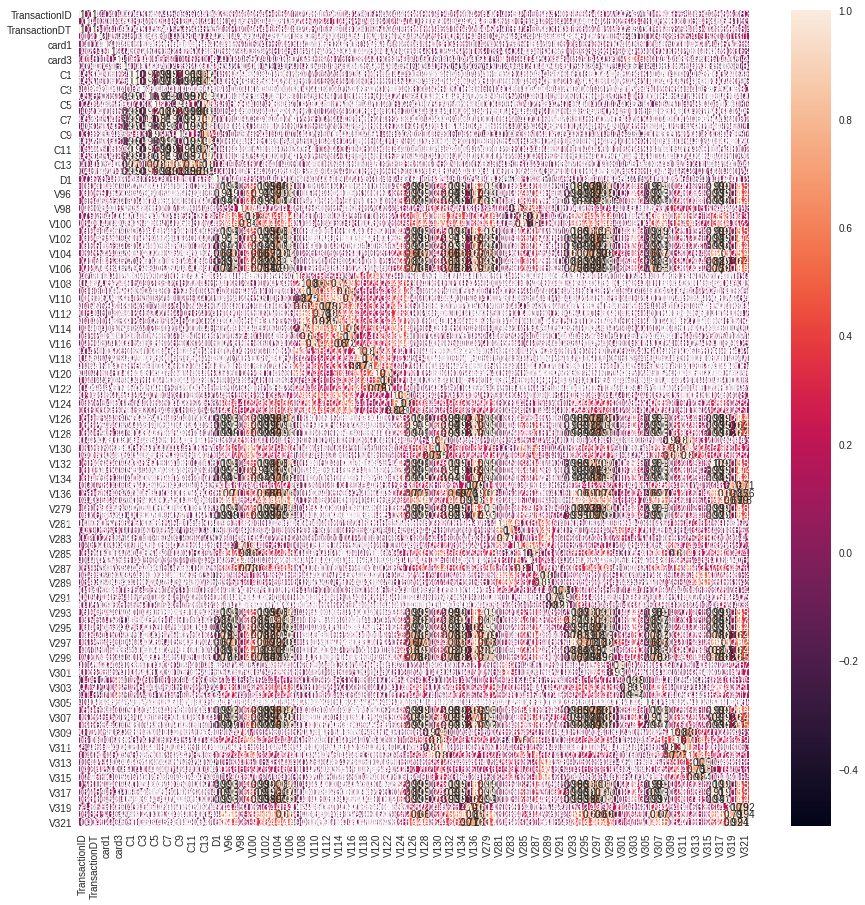

In [ ]:
corr = train.corr()
plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot=True)

In [ ]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000      0.0          86400            68.5         W  13926   
1        2987001      0.0          86401            29.0         W   2755   
2        2987002      0.0          86469            59.0         W   4663   
3        2987003      0.0          86499            50.0         W  18132   
4        2987004      0.0          86506            50.0         H   4497   

        card2  card3       card4  card5   card6   C1   C2   C3   C4   C5   C6  \
0  363.099769  150.0    discover  142.0  credit  1.0  1.0  0.0  0.0  0.0  1.0   
1  404.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0  0.0  0.0  1.0   
2  490.000000  150.0        visa  166.0   debit  1.0  1.0  0.0  0.0  0.0  1.0   
3  567.000000  150.0  mastercard  117.0   debit  2.0  5.0  0.0  0.0  0.0  4.0   
4  514.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0  0.0  0.0  1.0   

    C7   C8   C9  C10  C11  C12   C13  C14     D1  V95   V96   V97  V98   V99  \
0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0  0.0   1.0   0.0  0.0   0.0   
1  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   
2  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   
3  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  1.0  48.0  28.0  0.0  10.0   
4  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   

   V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  V111  \
0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
3   4.0   1.0  38.0  24.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   

   V112  V113  V114  V115  V116  V117  V118  V119  V120  V121  V122  V123  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V124  V125  V126    V127   V128  V129   V130   V131  V132    V133   V134  \
0   1.0   1.0   0.0   117.0    0.0   0.0    0.0    0.0   0.0   117.0    0.0   
1   1.0   1.0   0.0     0.0    0.0   0.0    0.0    0.0   0.0     0.0    0.0   
2   1.0   1.0   0.0     0.0    0.0   0.0    0.0    0.0   0.0     0.0    0.0   
3   1.0   1.0  50.0  1758.0  925.0   0.0  354.0  135.0  50.0  1404.0  790.0   
4   1.0   1.0   0.0     0.0    0.0   0.0    0.0    0.0   0.0     0.0    0.0   

   V135  V136  V137  V279  V280  V281  V282  V283  V284  V285  V286  V287  \
0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   1.0  28.0   0.0   0.0   0.0   0.0  10.0   0.0   4.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   

   V288  V289  V290  V291  V292  V293  V294  V295  V296  V297  V298  V299  \
0   0.0   0.0   1.0   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   1.0   1.0   1.0   1.0  38.0  24.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V300  V301  V302  V303  V304  V305  V306    V307   V308  V309   V310  V311  \
0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   117.0    0.0   0.0    0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   1.0   0.0     0.0    0.0   0.0    0.0   0.0

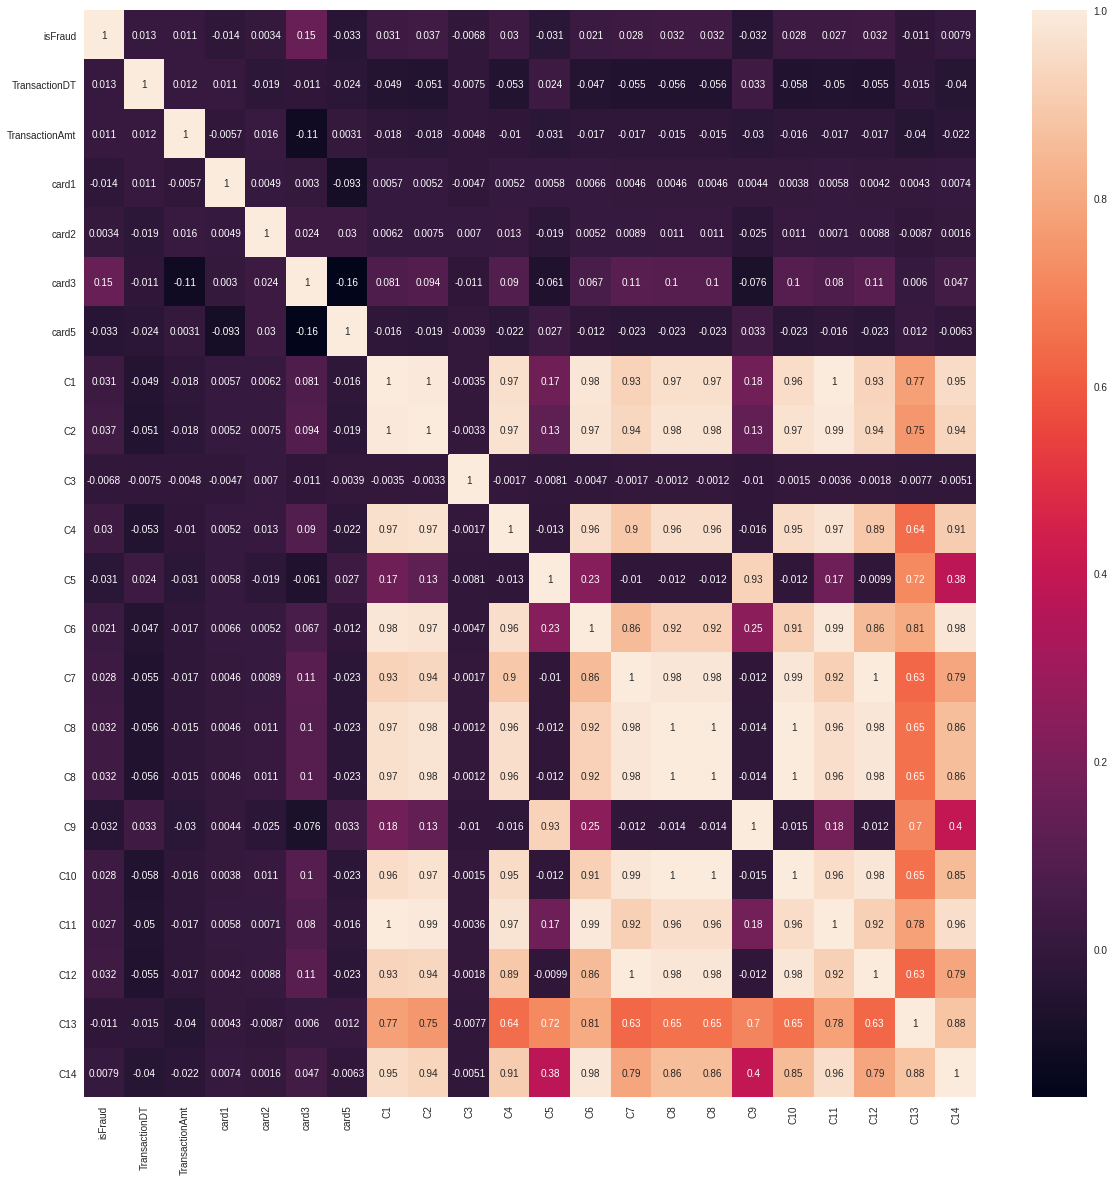

In [ ]:
templist = ['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
corr1 = train[templist].corr()
plt.subplots(figsize=(20, 20))
sns.heatmap (corr1, annot=True)

In [ ]:
#We concatenate the features again to encode categorical features.
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0, sort=False)
print(all_data.shape)

(1097231, 112)


In [ ]:
ntrain+ntest

1097231

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head()

(1097231, 122)


TransactionID  isFraud  TransactionDT  TransactionAmt  card1       card2  \
0        2987000      0.0          86400            68.5  13926  363.099769   
1        2987001      0.0          86401            29.0   2755  404.000000   
2        2987002      0.0          86469            59.0   4663  490.000000   
3        2987003      0.0          86499            50.0  18132  567.000000   
4        2987004      0.0          86506            50.0   4497  514.000000   

   card3  card5   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0  150.0  142.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   
1  150.0  102.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
2  150.0  166.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
3  150.0  117.0  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0   
4  150.0  102.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   

    C13  C14     D1  V95   V96   V97  V98   V99  V100  V101  V102  V103  V104  \
0   1.0  1.0   14.0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   
1   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3  25.0  1.0  112.0  1.0  48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   0.0   
4   1.0  1.0    0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  V116  \
0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V117  V118  V119  V120  V121  V122  V123  V124  V125  V126    V127   V128  \
0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   117.0    0.0   
1   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0    0.0   
2   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0    0.0   
3   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  50.0  1758.0  925.0   
4   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0    0.0   

   V129   V130   V131  V132    V133   V134  V135  V136  V137  V279  V280  \
0   0.0    0.0    0.0   0.0   117.0    0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0    0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0    0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0  354.0  135.0  50.0  1404.0  790.0   0.0   0.0   0.0   1.0  28.0   
4   0.0    0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0   0.0   0.0   

   V281  V282  V283  V284  V285  V286  V287  V288  V289  V290  V291  V292  \
0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   
1   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   
2   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   
3   0.0   0.0   0.0   0.0  10.0   0.0   4.0   0.0   0.0   1.0   1.0   1.0   
4   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   

   V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  V303  V304  \
0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   1.0  38.0  24.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   

   V305  V306    V307   V308  V309   V310  V311   V312  V313  V314  V315  \
0   1.0   0.0   117.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
1   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
2   1.0   0

In [ ]:
train

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000      0.0          86400           68.50         W   
1             2987001      0.0          86401           29.00         W   
2             2987002      0.0          86469           59.00         W   
3             2987003      0.0          86499           50.00         W   
4             2987004      0.0          86506           50.00         H   
...               ...      ...            ...             ...       ...   
590535        3577535      0.0       15811047           49.00         W   
590536        3577536      0.0       15811049           39.50         W   
590537        3577537      0.0       15811079           30.95         W   
590538        3577538      0.0       15811088          117.00         W   
590539        3577539      0.0       15811131          279.95         W   

        card1       card2  card3       card4  card5   card6   C1   C2   C3  \
0       13926  363.099769  150.0    discover  142.0  credit  1.0  1.0  0.0   
1        2755  404.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0   
2        4663  490.000000  150.0        visa  166.0   debit  1.0  1.0  0.0   
3       18132  567.000000  150.0  mastercard  117.0   debit  2.0  5.0  0.0   
4        4497  514.000000  150.0  mastercard  102.0  credit  1.0  1.0  0.0   
...       ...         ...    ...         ...    ...     ...  ...  ...  ...   
590535   6550  363.099769  150.0        visa  226.0   debit  2.0  1.0  0.0   
590536  10444  225.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
590537  12037  595.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
590538   7826  481.000000  150.0  mastercard  224.0   debit  1.0  1.0  0.0   
590539  15066  170.000000  150.0  mastercard  102.0  credit  2.0  1.0  0.0   

         C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1  V95  \
0       0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0  0.0   
1       0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
2       0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
3       0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0  112.0  1.0   
4       0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0    0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...  ...   
590535  0.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0  0.0   3.0  2.0   29.0  0.0   
590536  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
590537  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0  0.0   
590538  0.0  0.0  3.0  0.0  0.0  2.0  0.0  1.0  1.0   5.0  1.0   22.0  1.0   
590539  0.0  1.0  1.0  0.0  0.0  2.0  0.0  1.0  0.0   1.0  1.0    0.0  1.0   

         V96   V97  V98   V99  V100  V101  V102  V103  V104  V105  V106  V107  \
0        1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   
1        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
2        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
3       48.0  28.0  0.0  10.0   4.0   1.0  38.0  24.0   0.0   0.0   0.0   1.0   
4        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
...      ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
590535   1.0   0.0  0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
590536   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
590537   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
590538   4.0   1.0  1.0   1.0   1.0   0.0   3.0   0.0   0.0   0.0   0.0   1.0   
590539   1.0   1.0  0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   

        V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  \
0        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2        1.0   1.0   1.0   1.0  

In [ ]:
train.shape

(590540, 112)

In [ ]:
test

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224          31.950         W  10409  111.0   
1             3663550       18403263          49.000         W   4272  111.0   
2             3663551       18403310         171.000         W   4476  574.0   
3             3663552       18403310         284.950         W  10989  360.0   
4             3663553       18403317          67.950         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279          94.679         C  13832  375.0   
506687        4170236       34214287          12.173         C   3154  408.0   
506688        4170237       34214326          49.000         W  16661  490.0   
506689        4170238       34214337         202.000         W  16621  516.0   
506690        4170239       34214345          24.346         C   5713  168.0   

        card3       card4  card5   card6   C1   C2   C3   C4   C5   C6   C7  \
0       150.0        visa  226.0   debit  6.0  6.0  0.0  0.0  3.0  4.0  0.0   
1       150.0        visa  226.0   debit  3.0  2.0  0.0  0.0  0.0  1.0  0.0   
2       150.0        visa  226.0   debit  2.0  2.0  0.0  0.0  0.0  5.0  0.0   
3       150.0        visa  166.0   debit  5.0  2.0  0.0  0.0  1.0  1.0  0.0   
4       150.0  mastercard  117.0   debit  6.0  6.0  0.0  0.0  2.0  5.0  0.0   
...       ...         ...    ...     ...  ...  ...  ...  ...  ...  ...  ...   
506686  185.0  mastercard  224.0   debit  1.0  1.0  0.0  1.0  0.0  1.0  1.0   
506687  185.0  mastercard  224.0   debit  1.0  3.0  0.0  1.0  0.0  1.0  1.0   
506688  150.0        visa  226.0   debit  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
506689  150.0  mastercard  224.0   debit  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
506690  144.0        visa  147.0  credit  1.0  1.0  0.0  1.0  0.0  1.0  1.0   

         C8   C9  C10  C11  C12    C13  C14     D1  V95  V96  V97  V98  V99  \
0       0.0  6.0  0.0  5.0  1.0  115.0  6.0  419.0  0.0  1.0  0.0  0.0  1.0   
1       0.0  2.0  0.0  1.0  1.0   12.0  2.0  149.0  0.0  4.0  1.0  0.0  4.0   
2       0.0  4.0  0.0  2.0  0.0   22.0  2.0  137.0  0.0  5.0  0.0  0.0  3.0   
3       0.0  2.0  0.0  2.0  0.0    7.0  4.0   42.0  0.0  0.0  0.0  0.0  0.0   
4       0.0  5.0  0.0  6.0  0.0   14.0  6.0   22.0  1.0  3.0  1.0  1.0  3.0   
...     ...  ...  ...  ...  ...    ...  ...    ...  ...  ...  ...  ...  ...   
506686  0.0  0.0  0.0  1.0  1.0    1.0  1.0    0.0  0.0  0.0  0.0  0.0  0.0   
506687  2.0  0.0  2.0  1.0  1.0    3.0  1.0   16.0  0.0  0.0  0.0  0.0  0.0   
506688  0.0  1.0  0.0  1.0  0.0    1.0  1.0    0.0  0.0  0.0  0.0  0.0  0.0   
506689  0.0  1.0  0.0  1.0  0.0    1.0  1.0    0.0  0.0  0.0  0.0  0.0  0.0   
506690  1.0  0.0  1.0  1.0  1.0    1.0  1.0    0.0  0.0  0.0  0.0  0.0  0.0   

        V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  \
0        0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
1        1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
2        0.0   0.0   0.0   0.0   0.0   2.0   0.0   1.0   1.0   1.0   1.0   
3        0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
4        1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
506686   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
506687   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
506688   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
506689   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
506690   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   

        V111  V112  V113  V114  V115  V116  V117  V118  V119  V120  V121  \
0        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2       

In [ ]:
from sklearn.model_selection import train_test_split
Target = 'isFraud'

In [ ]:
X_train = all_data[all_data[Target].notnull()]
X_test = all_data[all_data[Target].isnull()]

In [ ]:
y_train = X_train[Target]
sub = pd.DataFrame()
sub['TransactionID'] = test.TransactionID

In [ ]:
X_train = X_train.drop(['TransactionID', Target], axis=1)
X_test = X_test.drop (['TransactionID', Target], axis=1)

In [ ]:
#We now split the set into training and testing set
#Now, the training set must be split to training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
print('Train shape {} \nValid shape {} \nTest Shape {}'. format(X_train.shape, X_valid.shape, X_test.shape))

Train shape (472432, 120) 
Valid shape (118108, 120) 
Test Shape (506691, 120)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score,confusion_matrix

In [ ]:
def val_res(y_valid, y_prob, verbose=True):
  scores = {}
  y_pred_class = [0 if x<0.5 else 1 for x in y_prob]
  scores['val_accuracy']  =   accuracy_score(y_valid, y_pred_class)
  scores['val_auc']       =   roc_auc_score(y_valid, y_prob)
  scores['val_f1']        =   f1_score(y_valid, y_pred_class, average = 'binary')
  scores['val_precision'] =   precision_score(y_valid, y_pred_class)
  scores['val_recall']    =   recall_score(y_valid, y_pred_class)
  cm = confusion_matrix(y_valid, y_pred_class)
  cm_df = pd.DataFrame(cm, columns=np.unique(y_valid), index = np.unique(y_valid))
  if verbose:
      print('\nValidation Accuracy      {:0.5f}'.format( scores['val_accuracy'] ))
      print('Validation   AUC         {:0.5f}'.format( scores['val_auc']   ))
      print('Validation Precision     {:0.5f}'.format(scores['val_precision']))
      print('Validation Recall        {:0.5f}'.format(scores['val_recall']))
      print('Validation  F1           %0.5f' %scores['val_f1'] )
  return scores , cm_df

In [ ]:
eval_res ={}

params = {}
params['tree_method'] = 'hist'
params['objective'] = 'binary:logistic'
params['booster'] = 'gbtree'
params['eta'] = 0.1
params['seed'] = 42
params['eval_metric'] ='auc'
params['subsample'] = 0.8
params['colsample_bytree'] =0.8
params['scale_pos_weight'] = 4
params['lambda'] = 3
params['alpha'] = 3

In [ ]:
print('Train shape {} \nValid shape {} \nTest Shape {}'. format(X_train.shape, X_valid.shape, X_test.shape))

Train shape (472432, 120) 
Valid shape (118108, 120) 
Test Shape (506691, 120)


In [ ]:
dtrain = xgb.DMatrix(X_train, label= y_train)
dvalid = xgb.DMatrix(X_valid, label= y_valid)

In [ ]:
model = xgb.train( params, dtrain, evals= [(dtrain, 'train'), ( dvalid, 'eval' ) ], evals_result = eval_res, num_boost_round=10000, early_stopping_rounds=200, verbose_eval =  100)

[0]	train-auc:0.830859	eval-auc:0.811234
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[100]	train-auc:0.932084	eval-auc:0.890931
[200]	train-auc:0.949991	eval-auc:0.897989
[300]	train-auc:0.961314	eval-auc:0.899446
[400]	train-auc:0.968382	eval-auc:0.898556
Stopping. Best iteration:
[280]	train-auc:0.959421	eval-auc:0.899742



In [ ]:
y_prob_valid = model.predict(dvalid, ntree_limit = model.best_ntree_limit)

In [ ]:
y_prob = model.predict(dvalid)
results, cm_df  = val_res(y_valid, y_prob, verbose = True)


Validation Accuracy      0.96972
Validation   AUC         0.89700
Validation Precision     0.57922
Validation Recall        0.43898
Validation  F1           0.49944


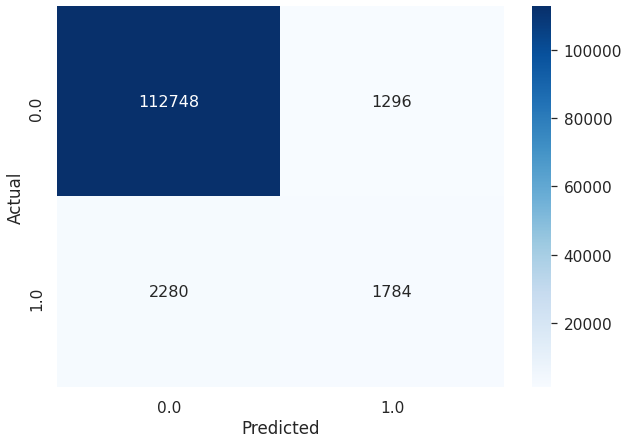

In [ ]:
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm_df, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

In [ ]:
def plot_xgb_scores(evals_result):
    train_res = evals_result['train']['auc']
    valid_res = evals_result['eval']['auc']
    ntrees = range(1, len(train_res) + 1)

    plt.figure(figsize = (12, 6))
    plt.plot(ntrees, train_res , 'b', label = 'Training')
    plt.plot(ntrees, valid_res, 'r', label = 'Validation')
    plt.xlabel('Number of Trees', fontsize = 20)
    plt.ylabel('AUC Score', fontsize = 20)
    plt.legend(fontsize = 14)
    plt.show()

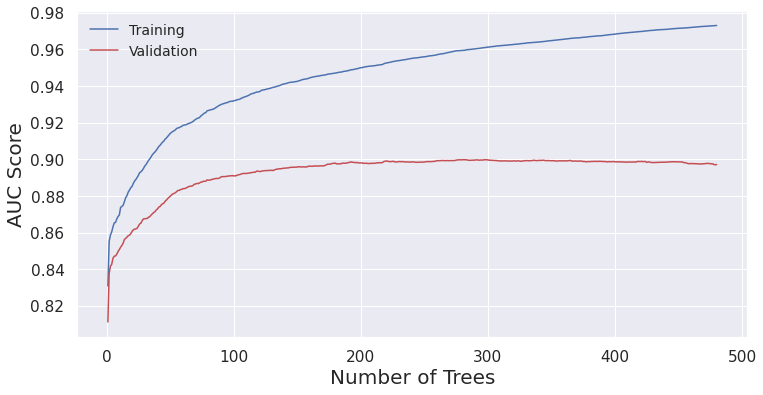

In [ ]:
plot_xgb_scores(eval_res)

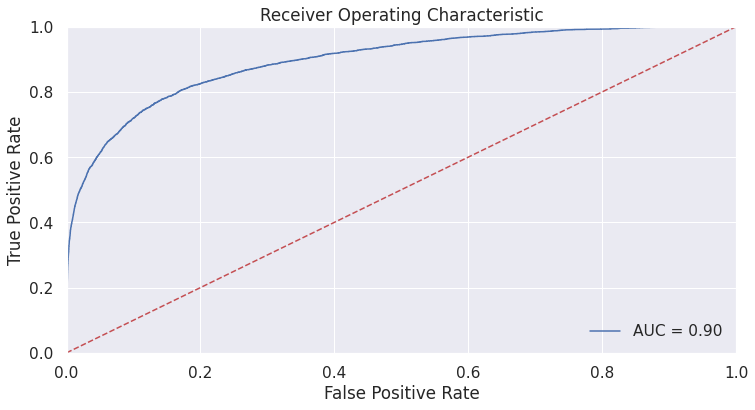

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize = (12, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def plot_feature_imp(model, top_n = 30):
    feature_imp = pd.DataFrame()
    xgb_featimp = model.get_score(importance_type='weight')
    feature_imp['feature'] = xgb_featimp.keys()
    feature_imp['importance']  = xgb_featimp.values()
    feature_imp = feature_imp.sort_values(by = 'importance', ascending= False )
    feature_imp_disp = feature_imp.head(top_n)
    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", data=feature_imp_disp)
    plt.title('XGBooost Features')
    plt.show() 

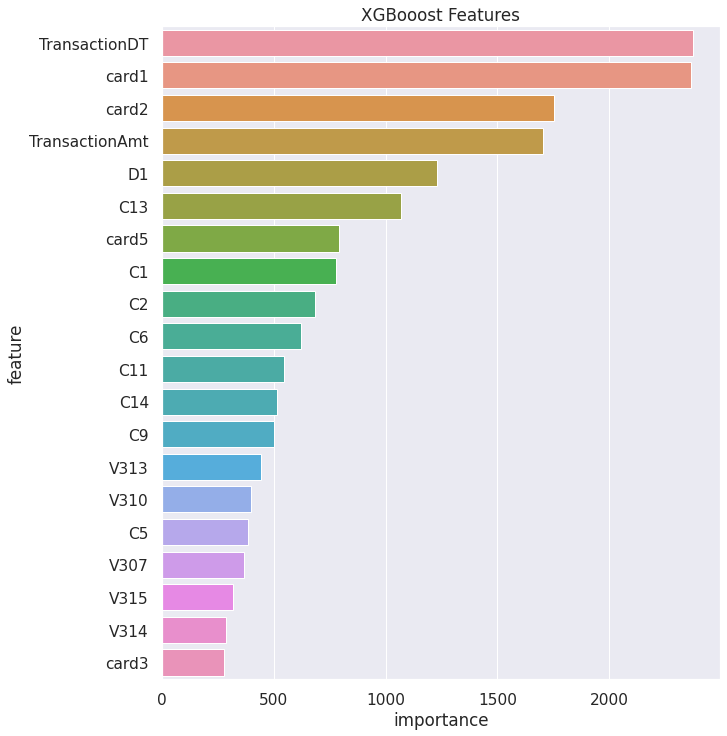

In [ ]:
plot_feature_imp(model, top_n = 20)

In [ ]:
dtest =  xgb.DMatrix(X_test)  
y_prob_test = model.predict(dtest)

In [ ]:
y_prob_test

array([0.00934123, 0.0161986 , 0.01470191, ..., 0.04605621, 0.07317469,
       0.01782784], dtype=float32)

In [ ]:
sub['isFraud'] = y_prob_test
sub.to_csv('lgb_sub.csv', index=False)
sub.head()

TransactionID   isFraud
0        3663549  0.009341
1        3663550  0.016199
2        3663551  0.014702
3        3663552  0.016216
4        3663553  0.005516